In [1]:
#from helper import IMAGE_RES
IMAGE_RES = 226

In [2]:
import os
import cv2
import time
import json
import keras
import tensorflow
import numpy as np
import seaborn as sns
from PIL import Image
import mediapipe as mp
import tensorflow as tf
from keras import backend as K
import matplotlib.pyplot as plt
from keras.regularizers import l2
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from keras.optimizers.schedules import ExponentialDecay
from keras.preprocessing.image import ImageDataGenerator
from helper import build_directory_lookup, get_subdirectory
from tensorflow.keras.callbacks import (
    EarlyStopping,
    LearningRateScheduler,
    ReduceLROnPlateau,
)
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
    GlobalAveragePooling2D
)

In [3]:
# training

# define the subdirectory where you training data is located
training_sub = "data/asl_alphabet_train"
testing_sub = "data/asl_alphabet_test"

training_path = get_subdirectory(training_sub)


Current Directory: c:\Users\navee\Projects\ASL-Fingerspelling-Recognition


In [4]:
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to be between 0 and 1
    horizontal_flip=True,  # Randomly flip images horizontally
    validation_split=0.3 # set data split
)

target_size = (IMAGE_RES, IMAGE_RES)  # Adjust according to your model's input size
batch_size = 512

In [5]:
# Use the ImageDataGenerator to load and preprocess images, split into training and validation sets
train_generator = datagen.flow_from_directory(
    training_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',  # Use 'binary' or 'categorical' based on your task
    subset='training'  # Specify 'training' for the training set
)

validation_generator = datagen.flow_from_directory(
    training_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',  # Use 'binary' or 'categorical' based on your task
    subset='validation'  # Specify 'validation' for the validation set
)
# Get the class (subdirectory) names
class_names = os.listdir(training_path)

Found 60900 images belonging to 29 classes.
Found 26100 images belonging to 29 classes.


In [6]:
num_rows = 3  # Adjust as needed
num_cols = (len(class_names) + num_rows - 1) // num_rows

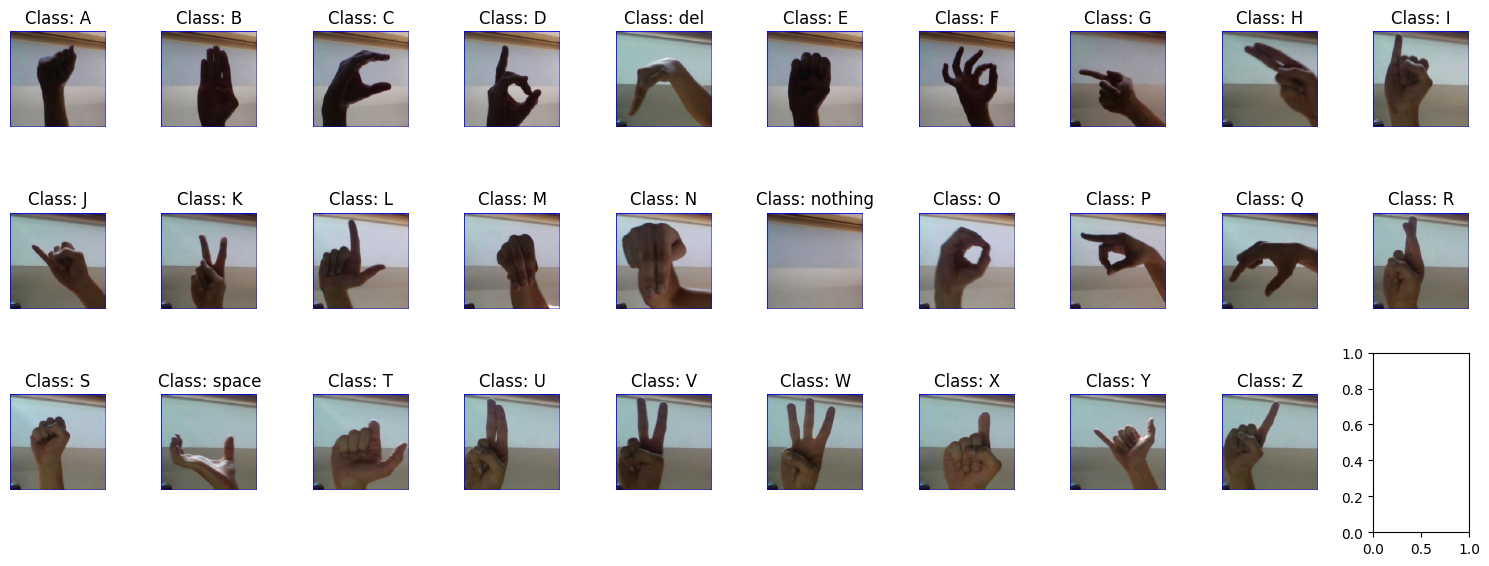

In [7]:
# Create a subplot with the specified number of rows and columns
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 6))

# Use the ImageDataGenerator to load and preprocess one image from each class
for i, class_name in enumerate(class_names):
    class_path = os.path.join(training_path, class_name)
    # Get a list of image file names in the class directory
    image_files = [f for f in os.listdir(class_path) if f.endswith('.jpg') or f.endswith('.png')]
    
    # Display the first image from each class in the grid
    img_path = os.path.join(class_path, image_files[0])
    img = image.load_img(img_path, target_size=target_size)
    axs[i // num_cols, i % num_cols].imshow(img)
    axs[i // num_cols, i % num_cols].set_title(f'Class: {class_name}')
    axs[i // num_cols, i % num_cols].axis('off')

# Adjust layout for better spacing
plt.tight_layout()

# Show the grid of images
plt.show()

In [8]:
# Get the statistics for training and validation sets
num_train_samples = train_generator.samples
num_validation_samples = validation_generator.samples
num_classes = train_generator.num_classes
class_indices = train_generator.class_indices
file_name = "data_lookup_train.json"
# Save the dictionary to a JSON file
with open(file_name, "w") as json_file:
    json.dump(class_indices, json_file)

# Display the statistics
print(f"Number of training samples: {num_train_samples}")
print(f"Number of validation samples: {num_validation_samples}")
print(f"Number of classes: {num_classes}")
print(f"Class indices: {class_indices}")

Number of training samples: 60900
Number of validation samples: 26100
Number of classes: 29
Class indices: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}


In [9]:
#num_classes = len(directory_reverse_lookup.keys())
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    'best_weights_offline.h5',
    monitor='val_loss',  # You can change this to 'val_accuracy' or any metric you prefer
    save_best_only=True,
    mode='min',  # Set to 'max' if monitoring accuracy
    verbose=1
)


# Model definition

model = keras.Sequential()
# Load VGG16 model and modify for ASL recognition
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMAGE_RES, IMAGE_RES, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling instead of Flatten
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

predictions = Dense(num_classes, activation='softmax')(x)  # Assuming there are 29 classes for ASL recognition

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001),# change learning rate to 0.001 for start
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Implement early stopping and learning rate scheduling
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
# lr_schedule = LearningRateScheduler(lr_scheduler)
lr_schedule = ReduceLROnPlateau(
    monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6, verbose=1
)
# Model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 226, 226, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 112, 112, 32)         0         ['batch_normalization[0][0

In [10]:
model.load_weights("best_weights.h5")

In [11]:
# Train the model using the fit method
history = model.fit(
    train_generator,
    steps_per_epoch=num_train_samples // batch_size,
    epochs=50,  # Adjust the number of epochs based on your requirements
    validation_data=validation_generator,
    validation_steps=num_validation_samples // batch_size,
    callbacks=[early_stopping, lr_schedule,checkpoint],
)

Epoch 1/50
118/118 [==============================] - ETA: 0s - loss: 0.2303 - accuracy: 0.9859
Epoch 1: val_loss improved from inf to 0.22282, saving model to best_weights_offline.h5


c:\Users\navee\Projects\ASL-Fingerspelling-Recognition\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


118/118 [==============================] - 1139s 10s/step - loss: 0.2303 - accuracy: 0.9859 - val_loss: 0.2228 - val_accuracy: 0.9872 - lr: 1.0000e-05
Epoch 2/50
118/118 [==============================] - ETA: 0s - loss: 0.2197 - accuracy: 0.9877
Epoch 2: val_loss improved from 0.22282 to 0.21940, saving model to best_weights_offline.h5
118/118 [==============================] - 1119s 10s/step - loss: 0.2197 - accuracy: 0.9877 - val_loss: 0.2194 - val_accuracy: 0.9861 - lr: 1.0000e-05
Epoch 3/50
118/118 [==============================] - ETA: 0s - loss: 0.2118 - accuracy: 0.9892
Epoch 3: val_loss improved from 0.21940 to 0.21789, saving model to best_weights_offline.h5
118/118 [==============================] - 1143s 10s/step - loss: 0.2118 - accuracy: 0.9892 - val_loss: 0.2179 - val_accuracy: 0.9864 - lr: 1.0000e-05
Epoch 4/50
118/118 [==============================] - ETA: 0s - loss: 0.2055 - accuracy: 0.9894
Epoch 4: val_loss did not improve from 0.21789
118/118 [===================

In [12]:
# Save the model weights
model.save_weights('final_weights_offline.h5')

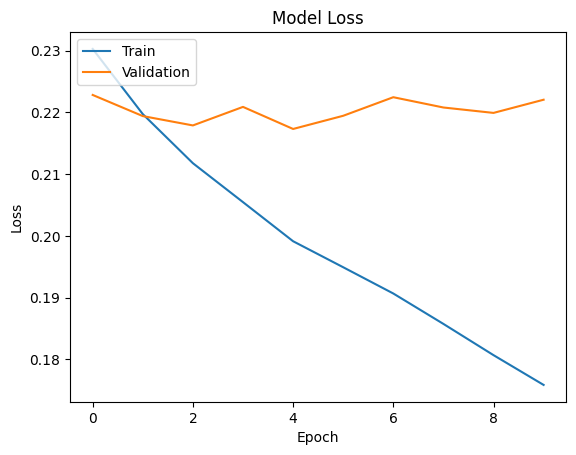

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()